# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
!pip install torch==1.7.1
!pip install torchvision==0.9.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 776.8 MB 8.9 kB/s  eta 0:00:01
ERROR: torchvision 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1 which is incompatible.
ERROR: torchtext 0.12.0 has requirement torch==1.11.0, but you'll have torch 1.7.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 17.3 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 735.5 MB 9.3 kB/s  eta 0:00:01
ERROR: torchtext 0.12.0 has requirement torch==1.11.0, but you'll have torch 1.8.0 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Consider adding this directory to PATH or, if yo

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [3]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [torchvision.transforms.ToPILImage(), ToTensor(), torchvision.transforms.Resize(size), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [4]:
import os


class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, directory: str, transforms: Callable = None, extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extenstion = extension
        

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        num_items = 0

        for path in os.listdir(data_dir):
            # check if current path is a file
            if os.path.isfile(os.path.join(data_dir, path)):
                num_items += 1
        
        return num_items - 1

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        files = [i for i in os.listdir(self.directory) if i[-4:] == ".jpg"]
        path = os.path.join(self.directory ,files[index])
        image = torchvision.io.read_image(path)
        image = self.transforms(image)
        return image

In [5]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

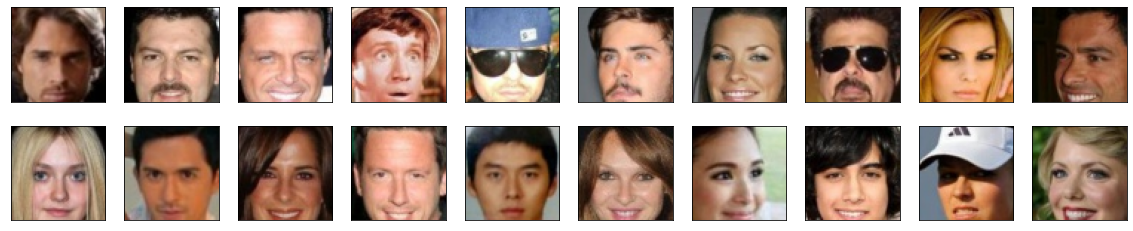

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [7]:
from torch.nn import Module
import torch
import torch.nn as nn

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            # We don't apply batch normalization to the first layer
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # 32 X 32 
            nn.LeakyReLU(0.2),
            
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(64, 64 * 2, 4, 2, 1), # 16 X 16
            self._block(64 * 2, 64 * 4, 4, 2, 1), # 8 X 8
            self._block(64 * 4, 64 * 8, 4, 2, 1), # 4 X 4
            
            
            
            
#             ###############################################################
#             nn.Flatten(),
#             nn.Linear(64*4*4*4*2, 1)
            
            
            ##############################################################################
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(64 * 8, 1, kernel_size=4, stride=2, padding=0), # 1 X 1
            nn.Sigmoid(),
         )
        

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [9]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [10]:
class Generator(nn.Module):
    def __init__(self, channels_noise):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
 
            self._block(channels_noise, 64 * 16, 4, 1, 0),  # img: 4x4x1024
            self._block(64 * 16, 64 * 8, 4, 2, 1),  # img: 8x8x512
            self._block(64 * 8, 64 * 4, 4, 2, 1),  # img: 16x16x256
            self._block(64 * 4, 64 * 2, 4, 2, 1),  # img: 32x32x128
            nn.ConvTranspose2d(
                64 * 2, 3, kernel_size=4, stride=2, padding=1
            ),
            # Output: 64x64x3
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias = False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [12]:
import torch.optim as optim


lr = 0.0002
beta1=0.5
beta2=0.999 


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr,  [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [13]:
def generator_loss(fake_logits,smooth = False):
    """ Generator loss, takes the fake scores as inputs. """
    
    batch_size = fake_logits.size(0)
    
    
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
        
    if train_on_gpu:
        labels = labels.cuda()
        

    criterion = nn.BCELoss()
    
    loss = criterion(fake_logits.squeeze(), labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [14]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    
    batch_size = fake_logits.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCELoss()
    fake_loss = criterion(fake_logits.squeeze(), labels)
    real_loss = generator_loss(real_logits)
    return fake_loss + real_loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [15]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [22]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    
    if train_on_gpu:
            z = z.cuda()
    
    fake_images = generator(z)


    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake)
    g_loss.backward()
    g_optimizer.step()

    return {'loss': g_loss}

In [23]:
def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()

    if train_on_gpu:
        real_images = real_images.cuda()

    D_real = discriminator(real_images)
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    
        
        
    if train_on_gpu:
        z = z.cuda()
    
    fake_images =generator(z)
    D_fake = discriminator(fake_images.detach())
    d_loss = discriminator_loss(D_real,D_fake)
    d_loss.backward()
    d_optimizer.step()

    return {'loss': d_loss}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [24]:
from datetime import datetime

In [25]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64

In [26]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()
# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [27]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-02-12 00:01:25 | Epoch [1/10] | Batch 0/509 | d_loss: 1.6078 | g_loss: 1.5102
2023-02-12 00:02:18 | Epoch [1/10] | Batch 50/509 | d_loss: 0.0537 | g_loss: 7.9298
2023-02-12 00:03:09 | Epoch [1/10] | Batch 100/509 | d_loss: 0.0042 | g_loss: 6.3448
2023-02-12 00:04:00 | Epoch [1/10] | Batch 150/509 | d_loss: 0.0359 | g_loss: 6.8550
2023-02-12 00:04:50 | Epoch [1/10] | Batch 200/509 | d_loss: 0.3255 | g_loss: 5.5639
2023-02-12 00:05:44 | Epoch [1/10] | Batch 250/509 | d_loss: 0.2398 | g_loss: 4.0242
2023-02-12 00:06:34 | Epoch [1/10] | Batch 300/509 | d_loss: 0.8678 | g_loss: 3.0525
2023-02-12 00:07:26 | Epoch [1/10] | Batch 350/509 | d_loss: 0.7362 | g_loss: 2.0790
2023-02-12 00:08:19 | Epoch [1/10] | Batch 400/509 | d_loss: 1.0861 | g_loss: 1.8020
2023-02-12 00:09:11 | Epoch [1/10] | Batch 450/509 | d_loss: 1.2403 | g_loss: 2.0021
2023-02-12 00:10:02 | Epoch [1/10] | Batch 500/509 | d_loss: 0.3091 | g_loss: 2.6991


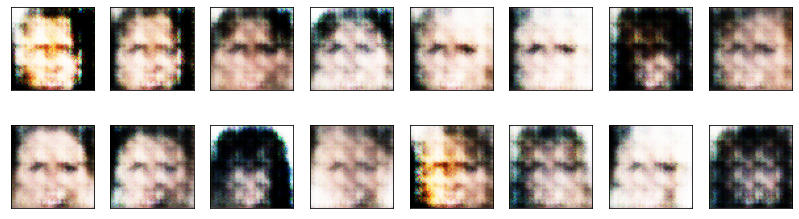

2023-02-12 00:10:14 | Epoch [2/10] | Batch 0/509 | d_loss: 0.4910 | g_loss: 2.4310
2023-02-12 00:11:08 | Epoch [2/10] | Batch 50/509 | d_loss: 0.3725 | g_loss: 3.7215
2023-02-12 00:12:02 | Epoch [2/10] | Batch 100/509 | d_loss: 0.9904 | g_loss: 1.4636
2023-02-12 00:12:53 | Epoch [2/10] | Batch 150/509 | d_loss: 0.9826 | g_loss: 2.2881
2023-02-12 00:13:47 | Epoch [2/10] | Batch 200/509 | d_loss: 1.3803 | g_loss: 2.1796
2023-02-12 00:14:39 | Epoch [2/10] | Batch 250/509 | d_loss: 0.7475 | g_loss: 7.5509
2023-02-12 00:15:31 | Epoch [2/10] | Batch 300/509 | d_loss: 0.3297 | g_loss: 4.1365
2023-02-12 00:16:24 | Epoch [2/10] | Batch 350/509 | d_loss: 2.6894 | g_loss: 9.0255
2023-02-12 00:17:16 | Epoch [2/10] | Batch 400/509 | d_loss: 0.3344 | g_loss: 2.4384
2023-02-12 00:18:11 | Epoch [2/10] | Batch 450/509 | d_loss: 0.2653 | g_loss: 2.9289
2023-02-12 00:19:00 | Epoch [2/10] | Batch 500/509 | d_loss: 0.4639 | g_loss: 4.5994


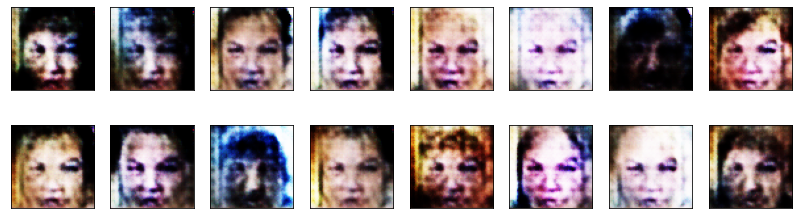

2023-02-12 00:19:14 | Epoch [3/10] | Batch 0/509 | d_loss: 0.8809 | g_loss: 5.0896
2023-02-12 00:20:07 | Epoch [3/10] | Batch 50/509 | d_loss: 0.2536 | g_loss: 2.4408
2023-02-12 00:20:59 | Epoch [3/10] | Batch 100/509 | d_loss: 2.2131 | g_loss: 3.7115
2023-02-12 00:21:48 | Epoch [3/10] | Batch 150/509 | d_loss: 0.7052 | g_loss: 3.6114
2023-02-12 00:22:40 | Epoch [3/10] | Batch 200/509 | d_loss: 0.4352 | g_loss: 4.7761
2023-02-12 00:23:31 | Epoch [3/10] | Batch 250/509 | d_loss: 0.6702 | g_loss: 2.5012
2023-02-12 00:24:23 | Epoch [3/10] | Batch 300/509 | d_loss: 0.1107 | g_loss: 4.3208
2023-02-12 00:25:16 | Epoch [3/10] | Batch 350/509 | d_loss: 1.0699 | g_loss: 2.8808
2023-02-12 00:26:06 | Epoch [3/10] | Batch 400/509 | d_loss: 0.4985 | g_loss: 4.7712
2023-02-12 00:26:57 | Epoch [3/10] | Batch 450/509 | d_loss: 0.2371 | g_loss: 2.0209
2023-02-12 00:27:47 | Epoch [3/10] | Batch 500/509 | d_loss: 0.0299 | g_loss: 6.3680


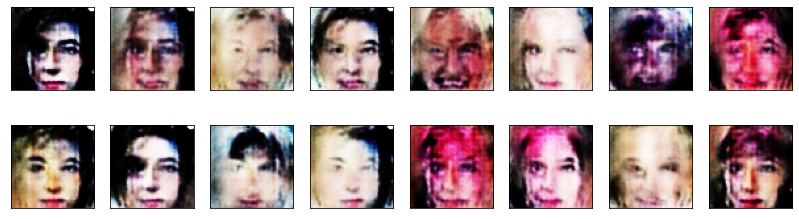

2023-02-12 00:28:00 | Epoch [4/10] | Batch 0/509 | d_loss: 0.1263 | g_loss: 3.5287
2023-02-12 00:28:52 | Epoch [4/10] | Batch 50/509 | d_loss: 0.4993 | g_loss: 2.6183
2023-02-12 00:29:43 | Epoch [4/10] | Batch 100/509 | d_loss: 0.5116 | g_loss: 2.5314
2023-02-12 00:30:33 | Epoch [4/10] | Batch 150/509 | d_loss: 0.2388 | g_loss: 3.3613
2023-02-12 00:31:25 | Epoch [4/10] | Batch 200/509 | d_loss: 0.6153 | g_loss: 2.4777
2023-02-12 00:32:15 | Epoch [4/10] | Batch 250/509 | d_loss: 0.1058 | g_loss: 5.2822
2023-02-12 00:33:06 | Epoch [4/10] | Batch 300/509 | d_loss: 2.0480 | g_loss: 2.5927
2023-02-12 00:33:59 | Epoch [4/10] | Batch 350/509 | d_loss: 0.2374 | g_loss: 3.3682
2023-02-12 00:34:50 | Epoch [4/10] | Batch 400/509 | d_loss: 0.0486 | g_loss: 6.5396
2023-02-12 00:35:40 | Epoch [4/10] | Batch 450/509 | d_loss: 0.3124 | g_loss: 3.1358
2023-02-12 00:36:31 | Epoch [4/10] | Batch 500/509 | d_loss: 0.0595 | g_loss: 3.3547


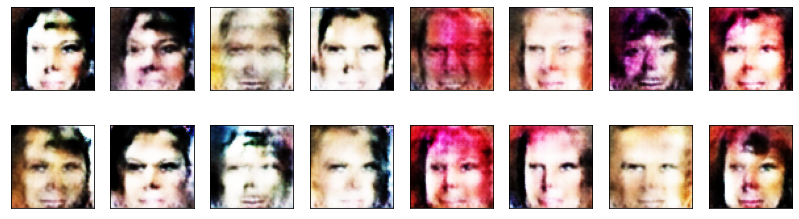

2023-02-12 00:36:44 | Epoch [5/10] | Batch 0/509 | d_loss: 0.0419 | g_loss: 6.5133
2023-02-12 00:37:37 | Epoch [5/10] | Batch 50/509 | d_loss: 0.0319 | g_loss: 4.5318
2023-02-12 00:38:29 | Epoch [5/10] | Batch 100/509 | d_loss: 0.1070 | g_loss: 6.3910
2023-02-12 00:39:20 | Epoch [5/10] | Batch 150/509 | d_loss: 0.0500 | g_loss: 4.4977
2023-02-12 00:40:11 | Epoch [5/10] | Batch 200/509 | d_loss: 0.6761 | g_loss: 5.6861
2023-02-12 00:41:04 | Epoch [5/10] | Batch 250/509 | d_loss: 0.0465 | g_loss: 3.3175
2023-02-12 00:41:56 | Epoch [5/10] | Batch 300/509 | d_loss: 0.1166 | g_loss: 7.6345
2023-02-12 00:42:48 | Epoch [5/10] | Batch 350/509 | d_loss: 0.1057 | g_loss: 2.6117
2023-02-12 00:43:38 | Epoch [5/10] | Batch 400/509 | d_loss: 1.0419 | g_loss: 7.2603
2023-02-12 00:44:30 | Epoch [5/10] | Batch 450/509 | d_loss: 0.0667 | g_loss: 4.1125
2023-02-12 00:45:23 | Epoch [5/10] | Batch 500/509 | d_loss: 0.0518 | g_loss: 4.7192


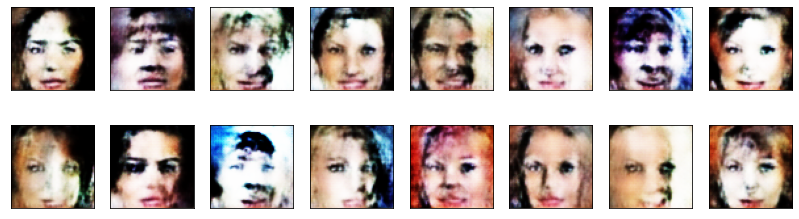

2023-02-12 00:45:34 | Epoch [6/10] | Batch 0/509 | d_loss: 0.0474 | g_loss: 5.6069
2023-02-12 00:46:26 | Epoch [6/10] | Batch 50/509 | d_loss: 0.0767 | g_loss: 3.9900
2023-02-12 00:47:16 | Epoch [6/10] | Batch 100/509 | d_loss: 0.0202 | g_loss: 2.8051
2023-02-12 00:48:07 | Epoch [6/10] | Batch 150/509 | d_loss: 0.1279 | g_loss: 3.3169
2023-02-12 00:48:57 | Epoch [6/10] | Batch 200/509 | d_loss: 0.0864 | g_loss: 5.0495
2023-02-12 00:49:46 | Epoch [6/10] | Batch 250/509 | d_loss: 0.4283 | g_loss: 5.4925
2023-02-12 00:50:37 | Epoch [6/10] | Batch 300/509 | d_loss: 0.4018 | g_loss: 6.5052
2023-02-12 00:51:31 | Epoch [6/10] | Batch 350/509 | d_loss: 0.2321 | g_loss: 2.8902
2023-02-12 00:52:20 | Epoch [6/10] | Batch 400/509 | d_loss: 0.0416 | g_loss: 2.4770
2023-02-12 00:53:12 | Epoch [6/10] | Batch 450/509 | d_loss: 0.0757 | g_loss: 5.5106
2023-02-12 00:54:02 | Epoch [6/10] | Batch 500/509 | d_loss: 4.0358 | g_loss: 5.1703


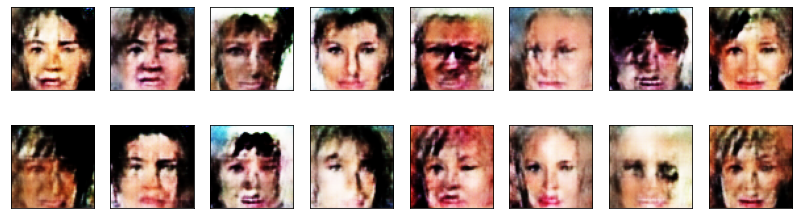

2023-02-12 00:54:15 | Epoch [7/10] | Batch 0/509 | d_loss: 0.2312 | g_loss: 3.0544
2023-02-12 00:55:06 | Epoch [7/10] | Batch 50/509 | d_loss: 0.0118 | g_loss: 6.4715
2023-02-12 00:55:57 | Epoch [7/10] | Batch 100/509 | d_loss: 0.0094 | g_loss: 6.7670
2023-02-12 00:56:47 | Epoch [7/10] | Batch 150/509 | d_loss: 0.3645 | g_loss: 4.1080
2023-02-12 00:57:37 | Epoch [7/10] | Batch 200/509 | d_loss: 0.0765 | g_loss: 6.4389
2023-02-12 00:58:30 | Epoch [7/10] | Batch 250/509 | d_loss: 0.2670 | g_loss: 4.2416
2023-02-12 00:59:22 | Epoch [7/10] | Batch 300/509 | d_loss: 0.1486 | g_loss: 2.6084
2023-02-12 01:00:11 | Epoch [7/10] | Batch 350/509 | d_loss: 0.1024 | g_loss: 6.9337
2023-02-12 01:01:03 | Epoch [7/10] | Batch 400/509 | d_loss: 0.0194 | g_loss: 6.6151
2023-02-12 01:01:55 | Epoch [7/10] | Batch 450/509 | d_loss: 0.0936 | g_loss: 3.7864
2023-02-12 01:02:46 | Epoch [7/10] | Batch 500/509 | d_loss: 0.2328 | g_loss: 4.5781


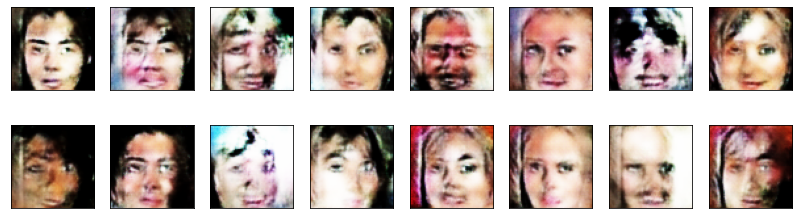

2023-02-12 01:02:58 | Epoch [8/10] | Batch 0/509 | d_loss: 0.0297 | g_loss: 4.9751
2023-02-12 01:03:49 | Epoch [8/10] | Batch 50/509 | d_loss: 0.5803 | g_loss: 4.1623
2023-02-12 01:04:41 | Epoch [8/10] | Batch 100/509 | d_loss: 0.0908 | g_loss: 4.0895
2023-02-12 01:05:31 | Epoch [8/10] | Batch 150/509 | d_loss: 0.0891 | g_loss: 3.7125
2023-02-12 01:06:22 | Epoch [8/10] | Batch 200/509 | d_loss: 0.0186 | g_loss: 4.9033
2023-02-12 01:07:14 | Epoch [8/10] | Batch 250/509 | d_loss: 0.5658 | g_loss: 2.7482
2023-02-12 01:08:06 | Epoch [8/10] | Batch 300/509 | d_loss: 0.0408 | g_loss: 3.9239
2023-02-12 01:08:58 | Epoch [8/10] | Batch 350/509 | d_loss: 0.1842 | g_loss: 3.2462
2023-02-12 01:09:48 | Epoch [8/10] | Batch 400/509 | d_loss: 0.6618 | g_loss: 9.8505
2023-02-12 01:10:41 | Epoch [8/10] | Batch 450/509 | d_loss: 0.0607 | g_loss: 4.9306
2023-02-12 01:11:33 | Epoch [8/10] | Batch 500/509 | d_loss: 0.2201 | g_loss: 5.1932


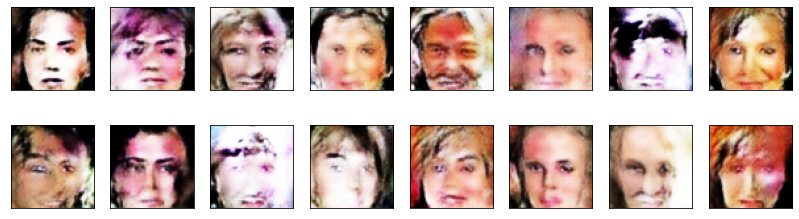

2023-02-12 01:11:44 | Epoch [9/10] | Batch 0/509 | d_loss: 0.3627 | g_loss: 4.4433
2023-02-12 01:12:37 | Epoch [9/10] | Batch 50/509 | d_loss: 0.0244 | g_loss: 7.2908
2023-02-12 01:13:29 | Epoch [9/10] | Batch 100/509 | d_loss: 0.0592 | g_loss: 6.6623
2023-02-12 01:14:21 | Epoch [9/10] | Batch 150/509 | d_loss: 0.1552 | g_loss: 4.9224
2023-02-12 01:15:11 | Epoch [9/10] | Batch 200/509 | d_loss: 0.0720 | g_loss: 5.0500
2023-02-12 01:16:04 | Epoch [9/10] | Batch 250/509 | d_loss: 0.2255 | g_loss: 4.3612
2023-02-12 01:16:56 | Epoch [9/10] | Batch 300/509 | d_loss: 0.4613 | g_loss: 3.2980
2023-02-12 01:17:47 | Epoch [9/10] | Batch 350/509 | d_loss: 0.1238 | g_loss: 2.9652
2023-02-12 01:18:38 | Epoch [9/10] | Batch 400/509 | d_loss: 0.0584 | g_loss: 4.9840
2023-02-12 01:19:32 | Epoch [9/10] | Batch 450/509 | d_loss: 0.0500 | g_loss: 3.0252
2023-02-12 01:20:22 | Epoch [9/10] | Batch 500/509 | d_loss: 0.0367 | g_loss: 4.0868


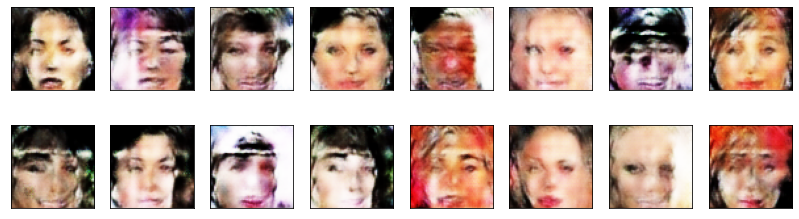

2023-02-12 01:20:34 | Epoch [10/10] | Batch 0/509 | d_loss: 0.0098 | g_loss: 7.2496
2023-02-12 01:21:26 | Epoch [10/10] | Batch 50/509 | d_loss: 0.0842 | g_loss: 5.5042
2023-02-12 01:22:18 | Epoch [10/10] | Batch 100/509 | d_loss: 0.3771 | g_loss: 4.3133
2023-02-12 01:23:08 | Epoch [10/10] | Batch 150/509 | d_loss: 0.0205 | g_loss: 7.2777
2023-02-12 01:24:00 | Epoch [10/10] | Batch 200/509 | d_loss: 0.0508 | g_loss: 3.0046
2023-02-12 01:24:52 | Epoch [10/10] | Batch 250/509 | d_loss: 0.0708 | g_loss: 3.9524
2023-02-12 01:25:43 | Epoch [10/10] | Batch 300/509 | d_loss: 2.8775 | g_loss: 4.4844
2023-02-12 01:26:35 | Epoch [10/10] | Batch 350/509 | d_loss: 0.1154 | g_loss: 2.3342
2023-02-12 01:27:25 | Epoch [10/10] | Batch 400/509 | d_loss: 0.1078 | g_loss: 3.3882
2023-02-12 01:28:17 | Epoch [10/10] | Batch 450/509 | d_loss: 0.0846 | g_loss: 4.0063
2023-02-12 01:29:06 | Epoch [10/10] | Batch 500/509 | d_loss: 0.2599 | g_loss: 3.8700


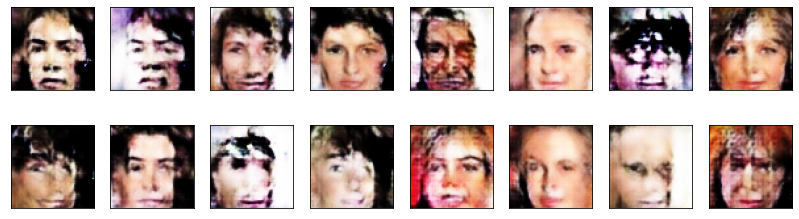

In [28]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        
        ####################################
        
        
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        g_loss = generator_step(batch_size, latent_dim)
        
    
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

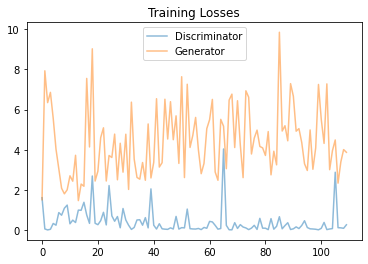

In [29]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** 


- Most of the generated images are females which indicates some bias in the dataset
- Most if not all generated images are white faces, which also indicates some bias in the dataset
- The far we go on epochs, the more realistic faces becomes
- I've used Adam as an optimizer and trained it for 10 epochs

In [ ]:
import shutil
shutil.rmtree('processed_celeba_small', ignore_errors=True)